<a href="https://colab.research.google.com/github/Hrishikap/gravitational-waves-/blob/main/miller_mass_ratios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-545368053>:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x600 with 0 Axes>

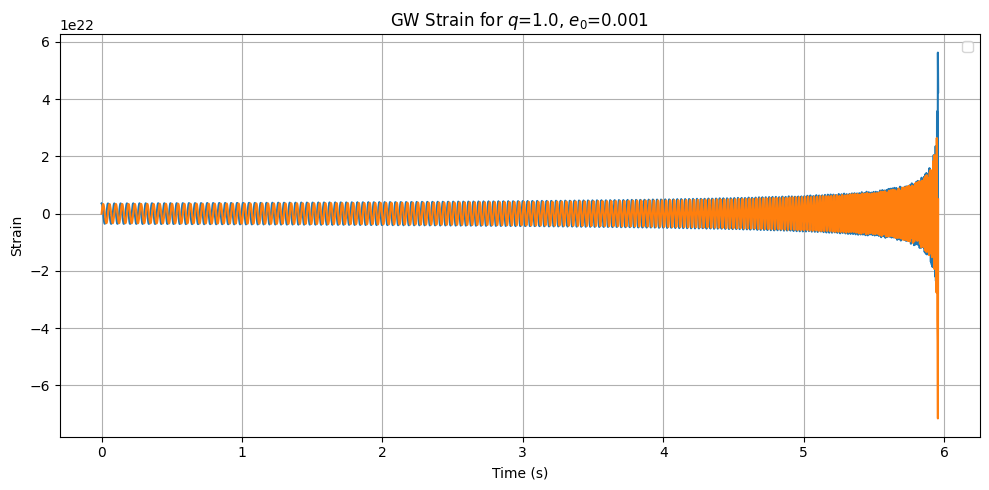

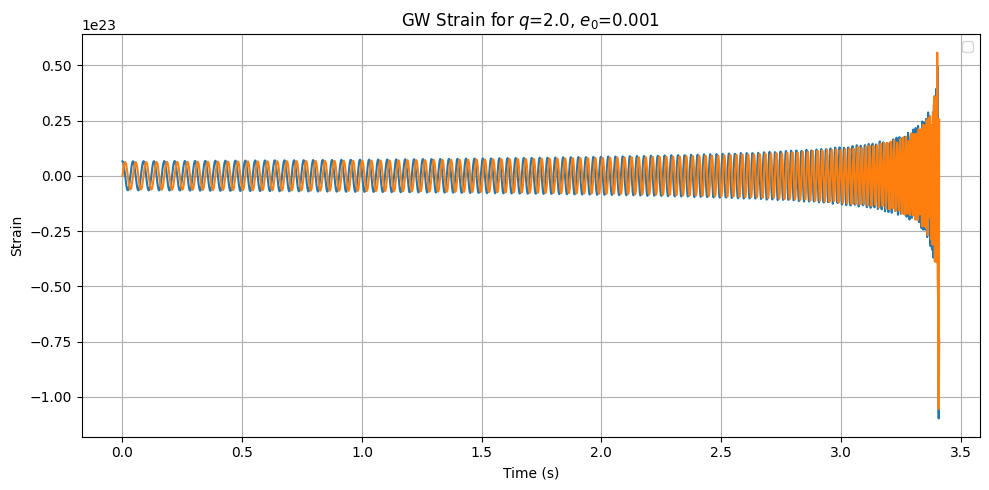

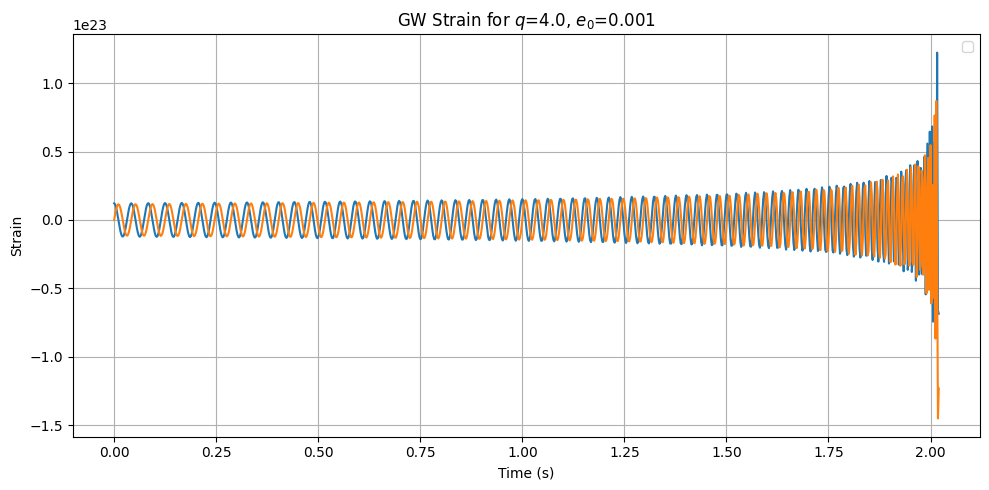

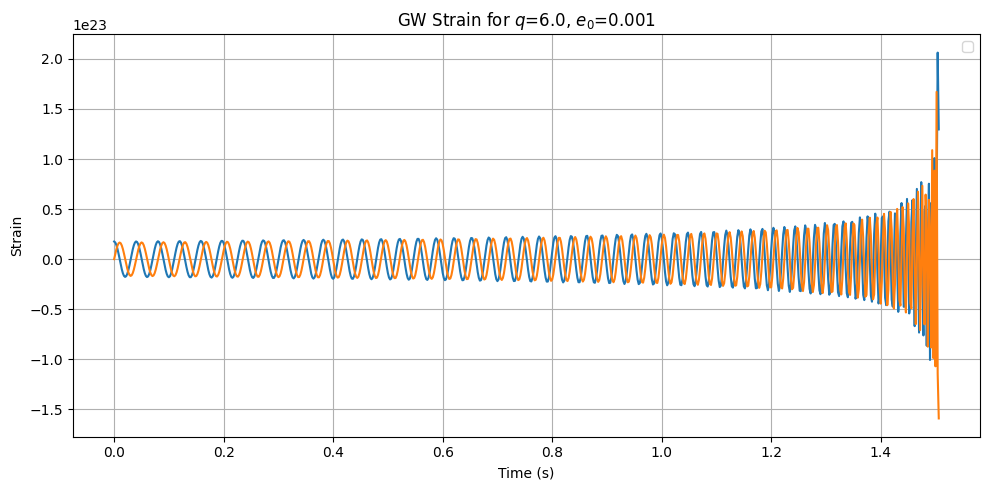

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ─── Constants ───────────────────────────────────────────────────────────────
G     = 6.67430e-11       # m^3 kg^-1 s^-2
c     = 299792458.0       # m/s
M_sun = 1.98847e30        # kg

# ─── Binary masses (SI) ──────────────────────────────────────────────────────
# Initial values (these will be updated in the loop)
m1 = 10 * M_sun
m2 = 10 * M_sun
M  = m1 + m2
μ  = m1*m2/M
D=1000e6*3.086e16

# ─── Initial orbital elements ────────────────────────────────────────────────
P0   = 0.1           # orbital period in seconds
a0   = (G*M*(P0/(2*np.pi))**2)**(1/3)
Ψ0   = 0.0                # true anomaly
theta=np.pi/4
e0 = 0.001

# ─── Time span & sampling ────────────────────────────────────────────────────
t_start = 0.0
t_end   = 20.0          # seconds
orbits  = (t_end - t_start)/P0
pts_per = 50
t_eval   = np.linspace(t_start, t_end, int(orbits*pts_per))

# ─── ODE system ──────────────────────────────────────────────────────────────
def deriv(t, y, m1, m2, M, G, c):
    r, a, e, Ψ, Φ = y

    # GW back-reaction (Peters 1964)
    a_dot = - (64/5) * G**3/(c**5) * (m1*m2*M) / a**3 \
            * (1 + 73/24*e**2 + 37/96*e**4) * (1-e**2)**(-7/2)
    e_dot = - (304/15)* G**3/(c**5) * (m1*m2*M) / a**4 * e \
            * (1 + 121/304*e**2) * (1-e**2)**(-5/2)

    # True anomaly rate
    Ψ_dot = np.sqrt(G*M/a**3) * (1 - e**2)**(-1.5) * (1 + e*np.cos(Ψ))**2

    # Periastron precession + Keplerian phase
    Φ_dot = Ψ_dot + 3 * (G*M)**1.5 / (c**2 * a**2.5 * (1 - e**2))

    # Radial derivative from r = a(1−e²)/(1 + e cosΨ)
    C1 = (1 - e**2)*a_dot / (1 + e*np.cos(Ψ))
    C2 = -2*a*e*e_dot    / (1 + e*np.cos(Ψ))
    C3 = -a*(1 - e**2)*( e_dot*np.cos(Ψ) -e*np.sin(Ψ)*Ψ_dot) \
         / (1 + e*np.cos(Ψ))**2
    r_dot = C1 + C2 + C3

    return [r_dot, a_dot, e_dot, Ψ_dot, Φ_dot]

plt.figure(figsize=(12, 6))
mass_ratios = [1.0, 2.0, 4.0 , 6.0]  # q = m2/m1

# Loop over mass ratios
for q in mass_ratios:
    m1 = 10 * M_sun
    m2 = q * m1
    M  = m1 + m2
    μ  = m1 * m2 / M
    a0 = (G * M * (P0/(2*np.pi))**2)**(1/3)
    r0 = a0*(1 - e0**2)/(1 + e0*np.cos(Ψ0))
    y0 = [r0, a0, e0, Ψ0, 0.0]

    sol = solve_ivp(deriv,
                    [t_start, t_end],
                    y0,
                    method='Radau',
                    t_eval=t_eval,
                    rtol=1e-8, atol=1e-10,
                    args=(m1, m2, M, G, c)) # Pass parameters here

    r_dot = np.gradient(sol.y[0], sol.t)
    phi_dot = np.gradient(sol.y[4], sol.t)
    phi_ddot = np.gradient(phi_dot, sol.t)
    r_ddot = np.gradient(r_dot, sol.t)
    r = sol.y[0]
    Phi = sol.y[4]

    h_plus = (
        (μ / (2 * D)) * (
            ((1 - 2 * np.cos(2 * theta)) * np.cos(Phi)**2 - 3 * np.cos(2 * Phi)) * r_dot**2 +
            (3 + np.cos(2 * theta)) * (2 * np.cos(2 * Phi) * phi_dot**2 + np.sin(2 * Phi) * phi_ddot) * r**2 +
            4 * (
                (3 + np.cos(2 * theta)) * np.sin(2 * Phi) * phi_dot * r_dot +
                ((1 - 2 * np.cos(2 * theta)) * np.cos(Phi)**2 - 3 * np.cos(2 * Phi)) * r_ddot
            ) * r
        )
    )

    h_cross = (
        (-2 * μ * np.cos(theta) / D) * (
            np.sin(2 * Phi) * r_dot**2 +
            (np.cos(2 * Phi) * phi_ddot - 2 * np.sin(2 * Phi) * phi_dot**2) * r**2 +
            (4 * np.cos(2 * Phi) * phi_dot * r_dot + np.sin(2 * Phi) * r_ddot) * r
        )
    )

    # Plot both strains
    plt.figure(figsize=(10, 5))
    plt.plot(sol.t, h_plus)
    plt.plot(sol.t, h_cross)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')
    plt.title(rf'GW Strain for $q$={q}, $e_0$={e0}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()